_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: Copilot Completions and o4-mini to explain concepts

# Coding Lab 2

## Introduction

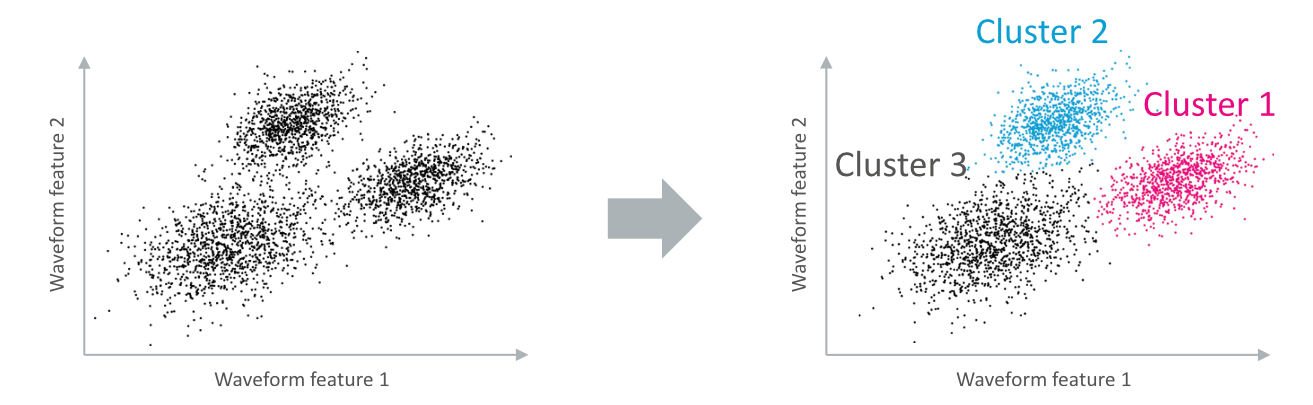

In this coding lab, we continue with the data from the first coding lab and finalize the Spike Sorting pipeline.
In particular, we use the created feature space to identify individual clusters by fitting a Gaussian Mixture Model.
To verify that this model does what we want, we first create a synthetic Toy Dataset and apply the model to that.

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-04 16:04:32Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

numpy     : 2.2.4
scipy     : 1.15.2
matplotlib: 3.10.1
sklearn   : 1.6.1

Watermark: 2.5.0



In [2]:
plt.style.use("matplotlib_style.txt")

## Load data

C:\Users\janni\AppData\Local\Temp\ipykernel_22396\1591429233.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


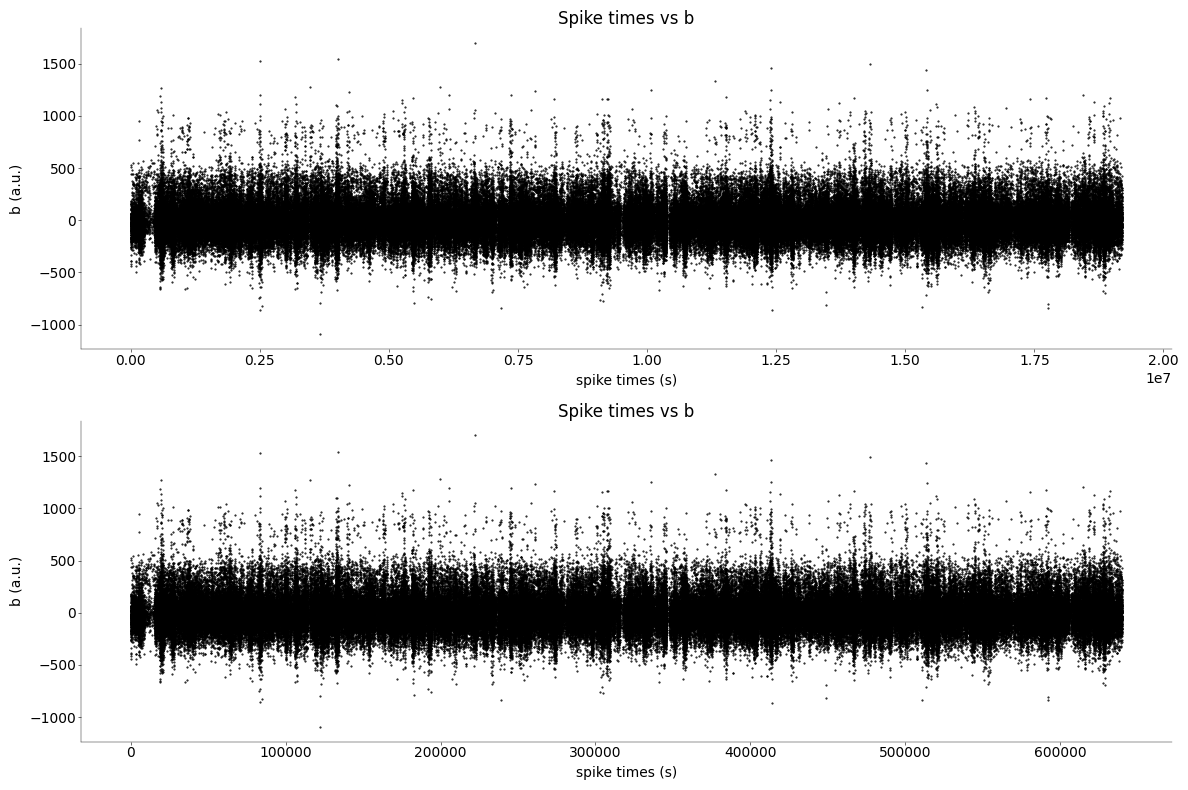

In [3]:
# replace by path to your solutions
b = np.load("nds_cl_1_features.npy")
s = np.load("nds_cl_1_spiketimes_s.npy")
t = np.load("nds_cl_1_spiketimes_t.npy")
w = np.load("nds_cl_1_waveforms.npy")

# plot the data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(s, b, "k.", markersize=1)
plt.xlabel("spike times (s)")
plt.ylabel("b (a.u.)")
plt.title("Spike times vs b")
plt.subplot(2, 1, 2)
plt.plot(t, b, "k.", markersize=1)
plt.xlabel("spike times (s)")
plt.ylabel("b (a.u.)")
plt.title("Spike times vs b")
plt.tight_layout()
plt.show()

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 2 pts*


In [4]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 0
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (1 pt)
    # ------------------------------------------------------

    labels = rng.multinomial(1, p, size=n_samples).argmax(axis=1)
    points = np.empty((n_samples, m.shape[1]))
    for i in range(m.shape[0]):
        points[labels == i] = rng.multivariate_normal(
            m[i], S[i], size=(labels == i).sum()
        )

    return (points, labels)

In [5]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

# labels, x = sample_data(N, m, S, p)

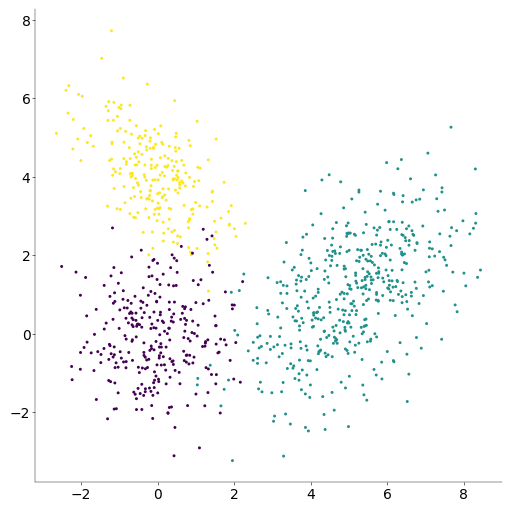

In [6]:
# ----------------------------------------------
# plot points from mixture of Gaussians (1 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
points, labels = sample_data(N, m, S, p)
ax.scatter(points[:, 0], points[:, 1], c=labels, s=5, cmap="viridis")

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 6 pts*


In [7]:
def fit_mog(
    x: np.ndarray,
    n_clusters: int,
    n_iters: int = 10,
    random_seed: int = 0,
    init: str = "random",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """
    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # -----------
    # init (1 pt)
    # -----------

    if init == "random":
        labels = rng.integers(0, n_clusters, size=x.shape[0])

        # perform one m-step to get initial m, S and p
        m = np.empty((n_clusters, x.shape[1]))
        S = np.empty((n_clusters, x.shape[1], x.shape[1]))
        p = np.empty(n_clusters)
        for i in range(n_clusters):
            m[i] = (
                x[labels == i].mean(axis=0)
                if (labels == i).sum() > 0
                else rng.random(x.shape[1])
            )
            S[i] = (
                np.cov(x[labels == i].T)
                if (labels == i).sum() > 1
                else np.eye(x.shape[1])
            )
            p[i] = (labels == i).sum() / x.shape[0]
        # Normalize `p` to ensure it sums to 1
        p /= p.sum()

    elif init == "kmeans":
        # use sklearn KMeans to get initial cluster centers
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed).fit(x)
        m = kmeans.cluster_centers_
        labels = kmeans.labels_
        # compute covariance matrices and cluster weights
        S = np.empty((n_clusters, x.shape[1], x.shape[1]))
        p = np.empty(n_clusters)
        for i in range(n_clusters):
            S[i] = np.cov(x[labels == i].T)
            p[i] = (labels == i).sum() / x.shape[0]

    # -------------------------
    # EM maximisation (3 pts)
    # -------------------------

    for step in range(n_iters):

        # E step
        r = np.empty(
            (x.shape[0], n_clusters)
        )  # x.shape[0] samples, n_clusters clusters
        # r is the posterior probability of each sample belonging to each cluster based on the current m, S and p
        for i in range(n_clusters):
            r[:, i] = p[i] * sp.stats.multivariate_normal.pdf(x, mean=m[i], cov=S[i])
        r /= r.sum(axis=1, keepdims=True)
        assert r.shape == (
            x.shape[0],
            n_clusters,
        ), "r must have shape (n_samples, n_clusters)"
        assert np.allclose(
            r.sum(axis=1), 1
        ), "r must be normalized to 1 for each sample"

        # M step
        # Update `m`, `S` and `p` using the posterior probabilities `r`
        m = np.empty((n_clusters, x.shape[1]))
        S = np.empty((n_clusters, x.shape[1], x.shape[1]))
        p = np.empty(n_clusters)
        for i in range(n_clusters):
            m[i] = (r[:, i] @ x) / r[:, i].sum()
            S[i] = (x - m[i]).T @ (r[:, i][:, np.newaxis] * (x - m[i])) / r[:, i].sum()
            p[i] = r[:, i].sum() / x.shape[0]
        # Normalize `p` to ensure it sums to 1
        p /= p.sum()

        # create labels based on the posterior probabilities
        labels = r.argmax(axis=1)

    return labels, m, S, p

Run Mixture of Gaussian on toy data

Text(0, 0.5, 'x2')

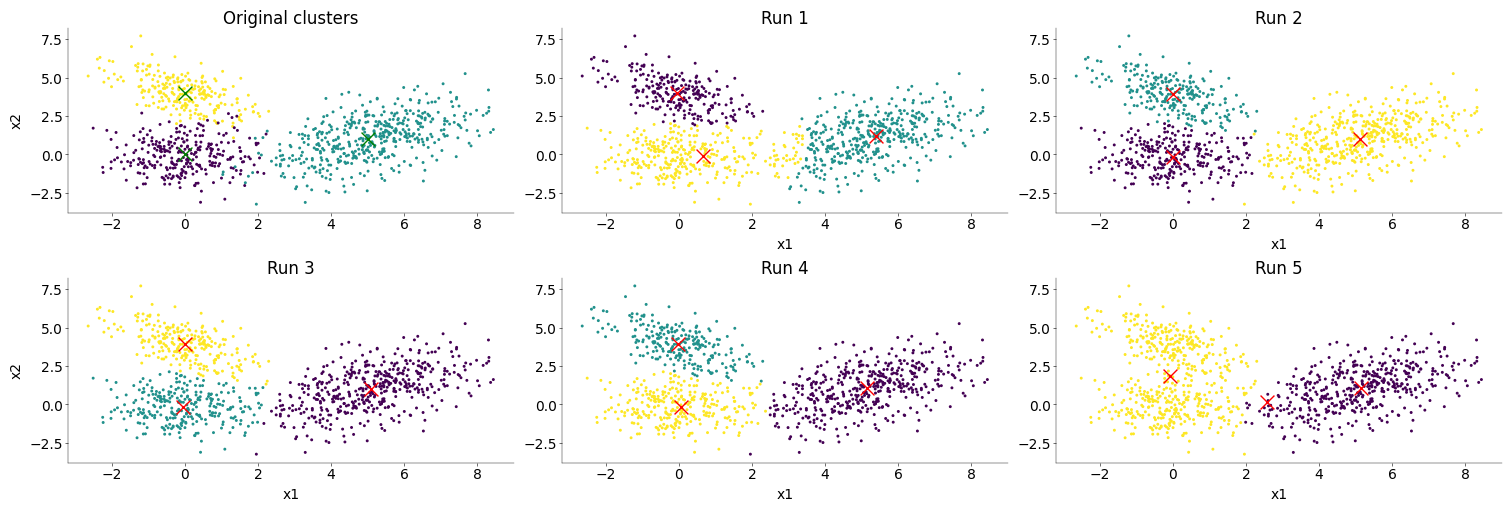

In [8]:
# -------------------------------------------------------------------------
# Run the algorithm 5 times on the toy data, plot and compare original and
# assigned clusters and answer the questions (1+1 pts)
# -------------------------------------------------------------------------


fig, axs = plt.subplots(2, 3, figsize=(15, 5), layout="constrained")
axs = axs.flatten()

axs[0].set_ylabel("x2")
axs[0].set_title("Original clusters")
axs[0].scatter(points[:, 0], points[:, 1], c=labels, s=5, cmap="viridis")
axs[0].scatter(m[:, 0], m[:, 1], c="green", s=100, marker="x")


for i in range(1, 6):
    # fit the model
    mog_labels, mog_m, mog_S, mog_p = fit_mog(points, 3, n_iters=30, random_seed=i)
    # plot the points and the clusters
    axs[i].scatter(points[:, 0], points[:, 1], c=mog_labels, s=5, cmap="viridis")
    axs[i].scatter(mog_m[:, 0], mog_m[:, 1], c="red", s=100, marker="x")
    axs[i].set_title(f"Run {i}")
    axs[i].set_xlabel("x1")

axs[3].set_ylabel("x2")

Text(0, 0.5, 'x2')

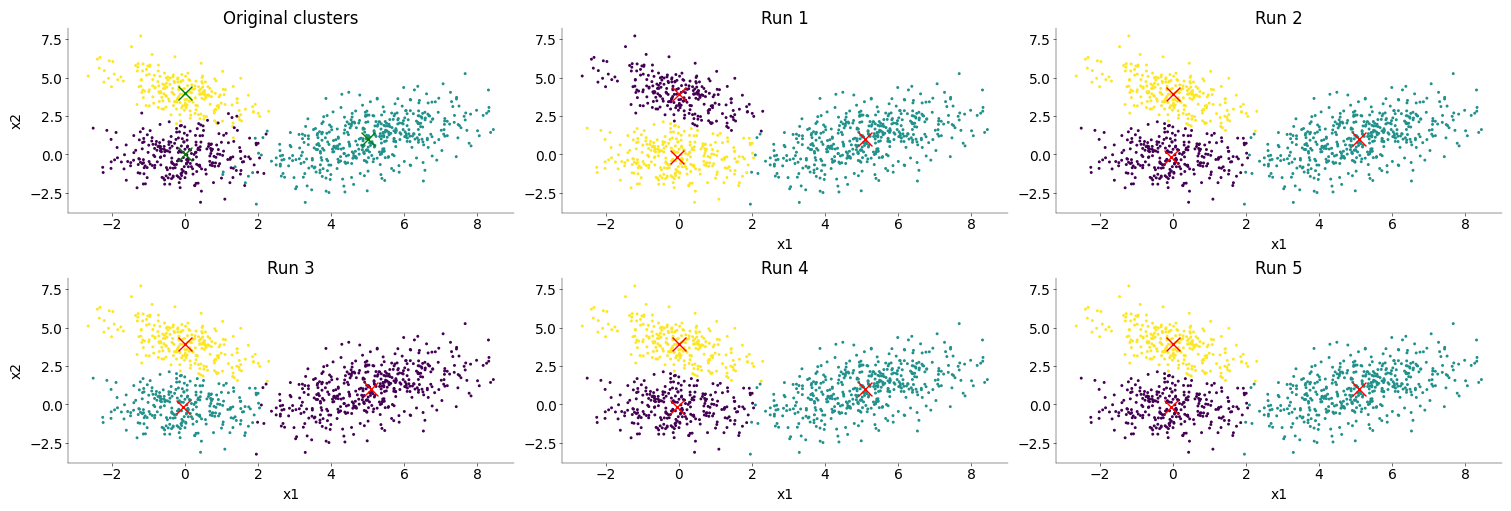

In [9]:
# -------------------------------------------------------------------------
# Here are some test runs based on kmeans initiliation for comparison
# -------------------------------------------------------------------------


fig, axs = plt.subplots(2, 3, figsize=(15, 5), layout="constrained")
axs = axs.flatten()

axs[0].set_ylabel("x2")
axs[0].set_title("Original clusters")
axs[0].scatter(points[:, 0], points[:, 1], c=labels, s=5, cmap="viridis")
axs[0].scatter(m[:, 0], m[:, 1], c="green", s=100, marker="x")


for i in range(1, 6):
    # fit the model
    mog_labels, mog_m, mog_S, mog_p = fit_mog(
        points, 3, n_iters=20, random_seed=i, init="kmeans"
    )
    # plot the points and the clusters
    axs[i].scatter(points[:, 0], points[:, 1], c=mog_labels, s=5, cmap="viridis")
    axs[i].scatter(mog_m[:, 0], mog_m[:, 1], c="red", s=100, marker="x")
    axs[i].set_title(f"Run {i}")
    axs[i].set_xlabel("x1")

axs[3].set_ylabel("x2")

### Questions

1) Do all runs converge to good solutions? If not, which one would you pick (only visual inspection required) as the best one?

No, many runs result suboptimal clusterings. This is especially the case for the randominitialization. Of these runs 3 and 4 look best visually. Initializing with k-means yields much more consistent results.

2) Do you get the same colors (=labels) in your best assignment(s) compared to the groundtruth? Does it have to be that way or not? Why?

No, because there exist equal optima that only differ by cluster indexing (= which cluster has which number). Crucial is, which points are in the same cluster.

## Bonus Task (Optional): Mixture of drifting t-distributions

Instead of a simple Gaussian Mixture Model, more advanced algorithms can be implemented.
Implement a basic version of the mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf).
What is the advantage of that method?

_Grading: 2 BONUS Points._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [10]:
# YOUR CODE HERE

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 5 pts*



### Question (0.5 pts)

1) What is the number of parameters of the model?

$P = N_\text{clusters}*N_\text{dim}+N_\text{clusters}*\frac{N_\text{dim}*(N_\text{dim}+1)}{2}+N_\text{clusters}-1$

In [11]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    n_samples, n_dims = x.shape
    n_clusters = m.shape[0]

    from scipy.stats import multivariate_normal
    from scipy.special import logsumexp

    log_probs = np.empty((n_samples, n_clusters))
    for j in range(n_clusters):
        # log weight + log N(x | m[j], S[j]) for all samples
        log_probs[:, j] = np.log(p[j]) + multivariate_normal.logpdf(
            x, mean=m[j], cov=S[j]
        )
    LL = float(np.sum(logsumexp(log_probs, axis=1)))

    # Number of parameters in the model
    n_params = (
        n_clusters * n_dims  # params for means
        + n_clusters * (n_dims * (n_dims + 1)) // 2  # params for covs
        + n_clusters
        - 1  # params for weights, -1 because p is normalized
    )

    bic = -2 * LL + n_params * np.log(n_samples)
    return bic, LL

In [12]:
# ----------------------------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your _estimate of the BIC_ robust against local minima, regardless of the initialization strategy used (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------

K = np.arange(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            points, k, n_iters=30, random_seed=j, init="random"
        )
        BIC[j, i], LL[j, i] = mog_bic(points, mog_m, mog_S, mog_p)
    robust_BIC[i] = BIC[:, i].min()

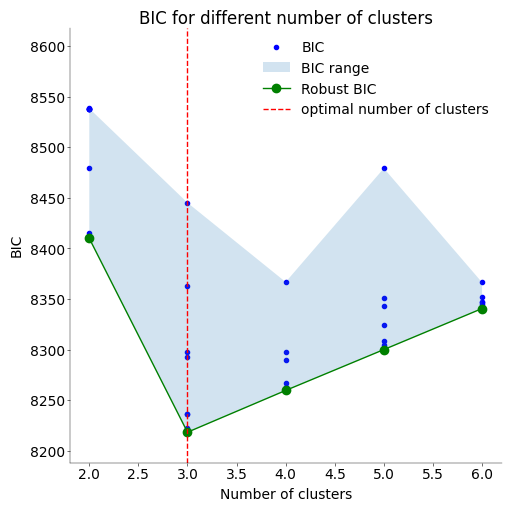

In [13]:
# ------------------------------------------------------------------------------------------
# Plot the result and answer the questions (1+1 pts)
# Don't forget to plot your robust estimate and highlight the estimated number of clusters!
# ------------------------------------------------------------------------------------------


fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

## scatter all BIC values
for i in range(num_seeds):
    ax.scatter(K, BIC[i], color="blue")

# dummy for adding to the legend
ax.scatter([], [], color="blue", label="BIC")

ax.fill_between(
    K,
    BIC.min(axis=0),
    BIC.max(axis=0),
    alpha=0.2,
    label="BIC range",
)
ax.plot(K, robust_BIC, "o-", label="Robust BIC", color="green")

ax.axvline(
    x=robust_BIC.argmin() + 2,
    color="red",
    linestyle="--",
    label="optimal number of clusters",
)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
ax.set_title("BIC for different number of clusters")
ax.set_ylim(BIC.min() - 30, BIC.max() + 80)
ax.legend()

### Questions

1) What happens to the BIC if the model got stuck in a local minimum? For your reasoning, you can also refer to Task 2.

When the algorithm gets stuck in a local minimum the log loss stops decreasing and with it the BIC. This means that our resulting BIC will not be the lowest possible for the chosen number of clusters. 

2) The goal is to estimate which number of clusters best fits the data using the BIC. Therefore, what qualifies as a robust estimate? Explain your reasoning!
   
_(Hint: think about which number of cluster you would use and why)_

As expected for our toy data wich was generated from three Gaussians, we get a BIC curve that indicates that thress clusters are optimal. But we see that for random initialization, we should do several runs and pick the best possible BIC achieved (because results are more varied than for kmeans initialization and we get stuck in bad local minima more often).  Otherwise we might choose a random seed where the BIC we want to choose (for n_clusters=3) is worse than another number of clusters because it got stuck in a worse local optimum. Chossing the best of several runs is a robust optimum, because we essentially choose the best optimum we could find in the loss landscape. Runs where we are "unlucky" and get a very high BIC do not influence the result (as opposed to choosing the mean BIC). The more initializations we try per number of clusters, the more robust our estimate gets.

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (MoG fitting + model complexity selection).

Show the plot of the BIC as a function of the number of mixture components on the real data, highlight the robust estimate and based on that the best number of clusters.

For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot.

*Grading: 3 pts*


In [14]:
# -------------------------------------------------------------
# Run the algorithm on the set of extracted features (0.5 pts)
# -------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            b, k, n_iters=20, random_seed=j, init="kmeans"
        )
        BIC[j, i], LL[j, i] = mog_bic(b, mog_m, mog_S, mog_p)
    robust_BIC[i] = BIC[:, i].min()
    print(f"robust BIC for {k} clusters: {robust_BIC[i]}")

robust BIC for 2 clusters: 2770123.0141990604
robust BIC for 3 clusters: 2747779.625988477
robust BIC for 4 clusters: 2737546.188315651
robust BIC for 5 clusters: 2734358.7706141686
robust BIC for 6 clusters: 2731867.94362652
robust BIC for 7 clusters: 2728447.1978121316
robust BIC for 8 clusters: 2728871.487380349
robust BIC for 9 clusters: 2726968.6652227137
robust BIC for 10 clusters: 2727456.7194625027
robust BIC for 11 clusters: 2728072.362268533
robust BIC for 12 clusters: 2726058.8838048796
robust BIC for 13 clusters: 2725794.222166432
robust BIC for 14 clusters: 2725658.4828667915
robust BIC for 15 clusters: 2726106.304162667


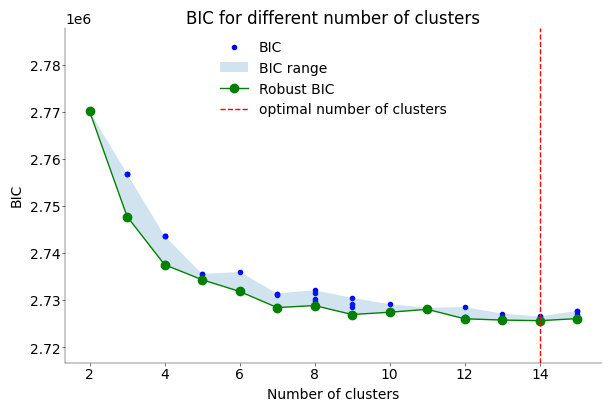

In [15]:
# ----------------------------------------------------------------------------------------------------------------------
# Plot the BIC over number of mixture components and highlight robust estimate and optimal number of clusters (0.5 pts)
# ----------------------------------------------------------------------------------------------------------------------


def plot_bic(BIC, K, num_seeds, robust_BIC):
    fig, ax = plt.subplots(figsize=(6, 4))
    ## scatter all BIC values
    for i in range(num_seeds):
        ax.scatter(K, BIC[i], color="blue")

    # dummy for adding to the legend
    ax.scatter([], [], color="blue", label="BIC")

    ax.fill_between(
        K,
        BIC.min(axis=0),
        BIC.max(axis=0),
        alpha=0.2,
        label="BIC range",
    )
    ax.plot(K, robust_BIC, "o-", label="Robust BIC", color="green")
    ax.axvline(
        x=robust_BIC.argmin() + 2,
        color="red",
        linestyle="--",
        label="optimal number of clusters",
    )
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("BIC")
    ax.set_title("BIC for different number of clusters")
    ax.set_ylim(
        BIC.min() - 0.2 * (BIC.max() - BIC.min()),
        BIC.max() + 0.4 * (BIC.max() - BIC.min()),
    )
    ax.legend()
    plt.show()


plot_bic(BIC, K, num_seeds, robust_BIC)

robust BIC for 2 clusters: 2762104.4388337675
robust BIC for 3 clusters: 2744454.4029810457
robust BIC for 4 clusters: 2739131.240524133
robust BIC for 5 clusters: 2734424.911457369
robust BIC for 6 clusters: 2732206.0823928295
robust BIC for 7 clusters: 2729173.452981157
robust BIC for 8 clusters: 2727980.3761902493
robust BIC for 9 clusters: 2728415.5868872083
robust BIC for 10 clusters: 2727907.454537472
robust BIC for 11 clusters: 2728502.34557331
robust BIC for 12 clusters: 2727566.9397371816
robust BIC for 13 clusters: 2728078.742920036
robust BIC for 14 clusters: 2726937.0369629525
robust BIC for 15 clusters: 2729878.666693546


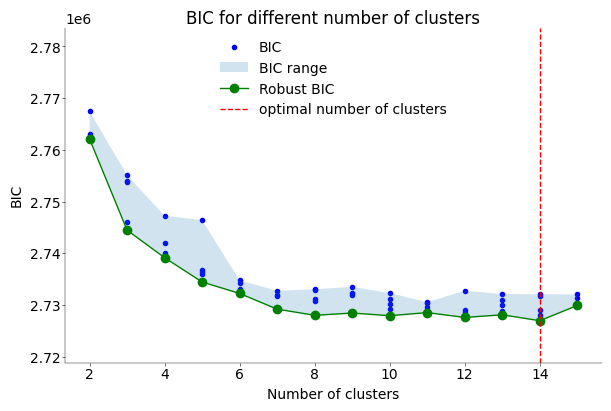

In [16]:
# ---------------------------------------------------------------
# For comparison: this is what it looks like with the less robust random initialization
# ---------------------------------------------------------------
K = np.arange(2, 16)
num_seeds = 5

BIC_randominit = np.zeros((num_seeds, len(K)))
LL_randominit = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
robust_BIC_randominit = np.zeros(len(K))
for i, k in enumerate(K):
    for j in range(num_seeds):
        mog_labels, mog_m, mog_S, mog_p = fit_mog(
            b, k, n_iters=20, random_seed=j, init="random"
        )
        BIC_randominit[j, i], LL_randominit[j, i] = mog_bic(b, mog_m, mog_S, mog_p)
    robust_BIC_randominit[i] = BIC_randominit[:, i].min()
    print(f"robust BIC for {k} clusters: {robust_BIC_randominit[i]}")

plot_bic(BIC_randominit, K, num_seeds, robust_BIC_randominit)

Refit model with lowest BIC and plot data points

In [17]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed, init="kmeans")

lowest BIC: # cluster = 14


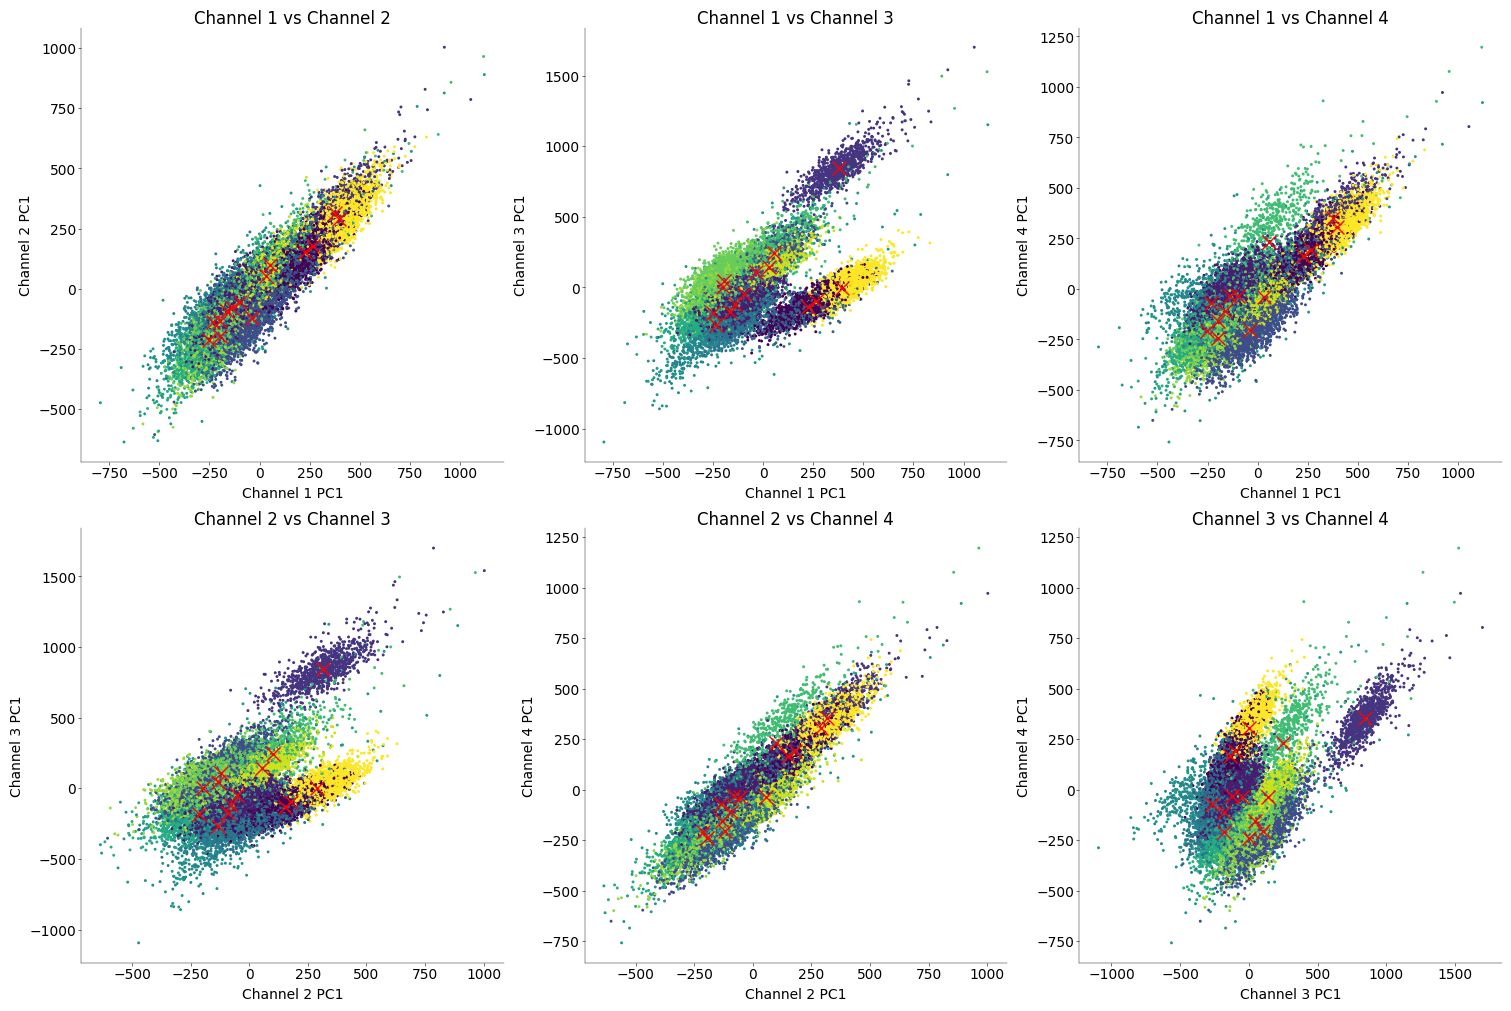

In [18]:
# ------------------------------------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all pairwise combinations of the 4 channels. (1 pt)
# ------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(15, 10), layout="constrained")
ax = ax.flatten()

channels = [0, 1, 2, 3]
channel_idx = [0, 3, 6, 9]

pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

for idx, (ch1, ch2) in enumerate(pairs):
    ax[idx].scatter(
        b[:, channel_idx[ch1]], b[:, channel_idx[ch2]], c=a, s=5, cmap="viridis"
    )
    ax[idx].scatter(
        m[:, channel_idx[ch1]], m[:, channel_idx[ch2]], c="red", s=100, marker="x"
    )
    ax[idx].set_xlabel(f"Channel {ch1 + 1} PC1")
    ax[idx].set_ylabel(f"Channel {ch2 + 1} PC1")
    ax[idx].set_title(f"Channel {ch1 + 1} vs Channel {ch2 + 1}")

plt.show()

## Task 5: Cluster separation and Correlograms

As postprocessing, implement the calculation of auto- and cross correlograms over the spike times.

Plot the (auto-/cross-) correlograms, displaying a time frame of -30ms to +30ms. Choose a good bin size and interprete the resulting diagrams.

_Grading: 3 pts_

#### Hints

_It is faster to calculate the histogram only over the spiketimes that are in the displayed range. Filter the spike times before calculating the histogram!_

_For the autocorrelogram, make sure not to include the time difference between a spike and itself (which would be exactly 0)_

_For the correlogram an efficient implementation is very important - looping over all spike times is not feasible. Instead, make use of numpy vectorization and broadcasting - you can use functions such as tile or repeat._

In [19]:
# ----------------------------------------------------------------------
# Implement a function for calculating the spike time differences (1pt)
# ----------------------------------------------------------------------
def cross_time_diff(spiketimes1: np.ndarray, spiketimes2: np.ndarray) -> np.ndarray:
    """Compute the pairwise time differences between two sets of spike times.

    Parameters
    ----------
    spiketimes1: np.ndarray, (n_spikes1, )
        Spike times of the first cluster
    spiketimes2: np.ndarray, (n_spikes2, )
        Spike times of the second cluster

    Return
    ------

    time_diff: np.ndarray, (n_spikes1, n_spikes2)
        Pairwise time differences between the two sets of spike times
        (i.e., spiketimes1[i] - spiketimes2[j])
    """
    pass

In [20]:
# -----------------------------------------------------------------------------------
# Calculate and plot auto- and cross correlograms and answer the questions (1+1 pts)
# -----------------------------------------------------------------------------------

### Questions
1) Based on the plot, do you see clusters that contain spikes likely from a single neuron?

_YOUR ANSWER HERE_

2) Do you see cases where plural clusters might come from the same neuron?

_YOUR ANSWER HERE_

3) Do you see clusters that might contain spikes from plural neurons?

_YOUR ANSWER HERE_

4) Explain the term "refractory period" and how one can see it in this plot.

_YOUR ANSWER HERE_